In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import logging
import scipy.stats as sts
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import os

from arch import arch_model

In [2]:
ini_work_dir = os.getcwd()
os.chdir('..')

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from antecedent_fitting import fit_antecedent_params
from local_models import calculate_retraining_garch_forecasts

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
RESEARCH_RESULTS_FOLDER = config['files_folders']['research_results']
antecedent_params_folder = config['files_folders']['antecedent_params_sets']
logs_folder = config['files_folders']['logs']

In [6]:
TESTED_MODEL_FILE_NAME = 'tested_model_wo_seas'

In [7]:
logger = logging.getLogger(f'test_calc_wo_seas')  # apf == antecedent params fitting

_log_file = f'{logs_folder}/{logger.name}.log'
logging.basicConfig(level=logging.INFO,
                    filename=_log_file,
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

In [8]:
pd.options.display.precision = 15
pd.options.display.max_colwidth = 300

# Reading

In [9]:
_files = ['fitting_consequent_params_wo_seas_result_nb_0_2022-09-25 18-56-38.347745.pkl']
res_big = [pd.read_pickle(f'{RESEARCH_RESULTS_FOLDER}/{_file}') for _file in _files]
_res = [_elem for res_piece in res_big for _elem in res_piece['result']].copy()

res = pd.DataFrame.from_records(_res).copy()

In [10]:
if (res['status'] != 0).any():
    raise Error('Not all models were fitted')

In [11]:
fitted_ap = res[res['rmse'] == res['rmse'].min()].iloc[0]['antecedent_params'].copy()
fitted_ap

[{'centers': (-7.5, 0.5, 3.5, 6.0),
  'variances': (4, 4, 4, 4),
  'n_clusters': 4}]

In [12]:
fvm = res[res['rmse'] == res['rmse'].min()].iloc[0]['fvm']

In [13]:
test = res_big[0]['test'].copy()
data_to_cluster_test = res_big[0]['data_to_cluster_test'].copy()

# Live feeding

In [14]:
%%time

fvm.feed_daily_data(test, data_to_cluster=data_to_cluster_test)

CPU times: user 5min 49s, sys: 5.04 s, total: 5min 54s
Wall time: 6min 53s


In [15]:
_cur_time = str(pd.Timestamp.today()).replace(':', '-')
print(_cur_time)

with open(f'{RESEARCH_RESULTS_FOLDER}/{TESTED_MODEL_FILE_NAME}_{_cur_time}.pkl', 'wb') as _file:
    pickle.dump(fvm, _file)

2022-09-26 00-16-39.372568


In [16]:
fvm.hist_output

2015-01-08    0.000471692125238
2015-01-09    0.004298278163680
2015-01-12    0.001030127084269
2015-01-13    0.000911157550797
2015-01-14    0.000630633229352
2015-01-15    0.000310714960803
2015-01-16    0.000648118232059
2015-01-19    0.000336928976519
2015-01-20    0.000295169424936
2015-01-21    0.000386485455462
2015-01-22    0.000909594388537
2015-01-23    0.001346007900438
2015-01-26    0.000304724714192
2015-01-27    0.001638959510211
2015-01-28    0.000302963629716
2015-01-29    0.000598958420790
2015-01-30    0.000605046818139
2015-02-02    0.000401354971506
2015-02-03    0.000370998243032
2015-02-04    0.001850360627553
2015-02-05    0.000538784209423
dtype: float128

In [17]:
fvm.membership_degrees_hist

,0,1,2,3
<DATE>,,,,
2015-01-08,3.556665089711452e-31,0.999999681058291,0.000000318941709,4.223778364417996e-20
2015-01-09,4.269313937713055e-31,0.999999702170193,0.000000297829807,3.725392126774580e-20
2015-01-12,4.388765301412337e-31,0.999999705236258,0.000000294763742,3.655382363652086e-20
2015-01-13,4.849510562314977e-31,0.999999716067088,0.000000283932912,3.412918185079057e-20
2015-01-14,5.129982574806421e-31,0.999999721990910,0.000000278009090,3.283511338243090e-20
2015-01-15,4.695590000849377e-31,0.999999712611996,0.000000287388004,3.489443706523359e-20
2015-01-16,4.240947596985547e-31,0.999999701424717,0.000000298575284,3.742505364673429e-20
2015-01-19,4.229772035527288e-31,0.999999701129134,0.000000298870866,3.749300659182727e-20
2015-01-20,4.028506309710628e-31,0.999999695614877,0.000000304385123,3.877096781334916e-20


In [18]:
fvm._parameters_hist

[{'alpha_0': array([1.32830985e-04, 2.51728612e-04, 1.99615522e+00, 1.30595283e-04]),
  'alpha': array([[0.23016584, 0.56761929, 0.03255053, 0.23016584]]),
  'beta': array([[5.17407912e-01, 4.58348757e-31, 7.01103084e-23, 5.17407912e-01]])},
 {'alpha_0': array([1.32830985e-04, 2.81534652e-04, 4.31396695e+00, 1.30595283e-04],
        dtype=float128),
  'alpha': array([[0.23016584, 0.56696178, 0.03314371, 0.23016584]], dtype=float128),
  'beta': array([[5.17407912e-01, 5.77235722e-13, 6.33820321e-13, 5.17407912e-01]],
        dtype=float128)},
 {'alpha_0': array([1.32830985e-04, 2.80626724e-04, 9.03006247e+00, 2.35678274e+00]),
  'alpha': array([[0.21864152, 0.54913998, 0.03233126, 0.23016584]]),
  'beta': array([[5.17407912e-01, 1.14963012e-13, 1.15014313e-13, 5.17407912e-01]])},
 {'alpha_0': array([1.32830985e-04, 2.84863750e-04, 1.04139624e-01, 2.35678274e+00]),
  'alpha': array([[0.21864152, 0.54906054, 0.01162798, 0.23016584]]),
  'beta': array([[5.17407912e-01, 3.25941913e-12, 3.25

In [19]:
res_big[0].keys()

dict_keys(['result', 'fitted', 'train', 'test', 'antecedent_params_set', 'consequent_metaparams', 'consequent_params_ini', 'clusterization_method', 'local_method', 'data_to_cluster_train', 'data_to_cluster_test'])

In [20]:
mse = mean_squared_error(fvm.hist_output, test ** 2, squared=True)
rmse = mean_squared_error(fvm.hist_output, test ** 2, squared=False)

In [21]:
rmse

0.0018784171608436488696

In [22]:
mse

3.528451030151914628e-06

<AxesSubplot:xlabel='<DATE>'>

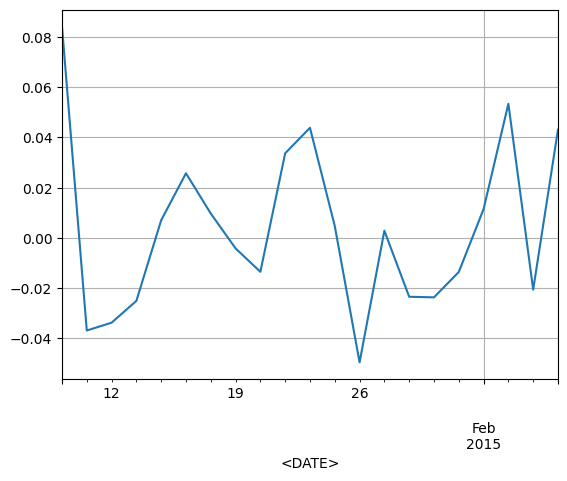

In [23]:
test.plot(grid=True)